## Lab 05: State of the Union Addresses (2/2)

[![Washington](Washington_sotu.jpg)](https://en.wikipedia.org/wiki/File:Washington_-_State_of_the_Union.djvu)

In this lab we will continue working the transcripts of the State of the Union addresses. This time we will build a type of "social network" of who refers to whom. We'll first restrict to the presidents themselves, and then expand the set of people. We'll get some more practice with the skills used in the Gutenberg books, and see how to draw certain types of networks in Python.

<br>



## 1. Loading in the data

You know the beginning routine...

In [1]:
from datascience import *
import numpy as np
import re

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')


Recall the `json` format for our transcripts:

```
{
   "date": "2017-02-28",
   "president": "Donald J. Trump",
   "title": "Address Before a Joint Session of the Congress",
   "url": "http://www.presidency.ucsb.edu/ws/index.php?pid=123408",
   "transcript": "Thank you very much. Mr. Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States, and citizens of America: Tonight, as we mark the conclusion of our celebration of Black History Month, we are reminded of our Nation's path towards civil rights and the work that still remains to be done. Recent threats targeting Jewish community centers and vandalism of Jewish cemeteries, as well as last week's shooting in Kansas City, remind us that while we may be a nation divided on policies, we are a country that stands united in condemning hate and evil in all of its very ugly forms. Each American generation passes the torch of truth, liberty, and justice in an unbroken chain, all the way down to the present. That torch is now in our hands, and we will use it to light up the world. I am here tonight to deliver a message of unity and strength, and it is a message deeply delivered from my heart.
```

As before, we'll read this in with the `json` package and load the meta-data and transcript for each speech into a `Table`. This is the same code from Lab 04.

In [2]:
import json
with open('transcripts.json') as f:
    data = json.load(f)
    
import datetime

dates = []
presidents = []
transcripts = []
years = []

for a in np.arange(len(data)):
    dates.append(data[a]['date'])
    presidents.append(data[a]['president'])
    transcripts.append(data[a]['transcript'])
    year = datetime.datetime.strptime(data[a]['date'], "%Y-%m-%d").year
    years.append(year)

speeches = Table().with_columns('Date', dates, 'Year', years, 'President', presidents, 'Transcript', transcripts)
speeches = speeches.sort('Date', descending=True)
speeches.show(16)
speeches.sort('Date', descending=False).show(16)

Date,Year,President,Transcript
2019-02-05,2019,Donald J. Trump,"Madam Speaker, Mr. Vice President, Members of Congress, ..."
2018-01-30,2018,Donald J. Trump,"Mr. Speaker, Mr. Vice President, Members of Congress, th ..."
2017-02-28,2017,Donald J. Trump,"Thank you very much. Mr. Speaker, Mr. Vice President, Me ..."
2016-01-12,2016,Barack Obama,"Thank you. Mr. Speaker, Mr. Vice President, Members of C ..."
2015-01-20,2015,Barack Obama,"The President. Mr. Speaker, Mr. Vice President, Members ..."
2014-01-28,2014,Barack Obama,"The President. Mr. Speaker, Mr. Vice President, Members ..."
2013-02-12,2013,Barack Obama,"Please, everybody, have a seat. Mr. Speaker, Mr. Vice Pr ..."
2012-01-24,2012,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Congress, di ..."
2011-01-25,2011,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Congress, di ..."
2010-01-27,2010,Barack Obama,"Madam Speaker, Vice President Biden, Members of Congress ..."


Date,Year,President,Transcript
1790-01-08,1790,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1790-12-08,1790,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1791-10-25,1791,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1792-11-06,1792,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1793-12-03,1793,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1794-11-19,1794,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1795-12-08,1795,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1796-12-07,1796,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1797-11-22,1797,John Adams,Gentlemen of the Senate and Gentlemen of the House of Re ...
1798-12-08,1798,John Adams,Gentlemen of the Senate and Gentlemen of the House of Re ...


And here is our function to plot the counts of a particular word. We'll add a hook allowing us to toggle whether to display it as a barplot or curve.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def mentions_of_word(word, show_table=False, curve=False):
    word = word.lower()
    count = []
    for s in np.arange(speeches.num_rows):
        matches = re.findall('\s%s\s' % word, speeches.column('Transcript')[s].lower())
        count.append(len(matches))
    
    sotu = speeches.with_columns('Count', count)
    if (show_table):
        sotu.show(10)

    fig = plt.figure()
    fig.set_size_inches(11,4)
    if curve:
        plt.plot(sotu.column('Year'), sotu.column('Count'), alpha=0.5, color='darkblue', linewidth=2)
    else:
        plt.bar(sotu.column('Year'), sotu.column('Count'), align='center', alpha=0.5, color='salmon')
    plt.xlabel('year')
    plt.ylabel('count')
    plt.title('Mentions of "%s"' % word)
    plt.show()
    


Let's go ahead and plot a few, starting with a couple of things that are inevitable in life, so they say. Run the following:

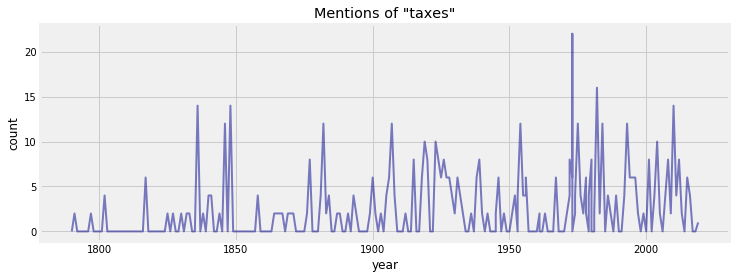

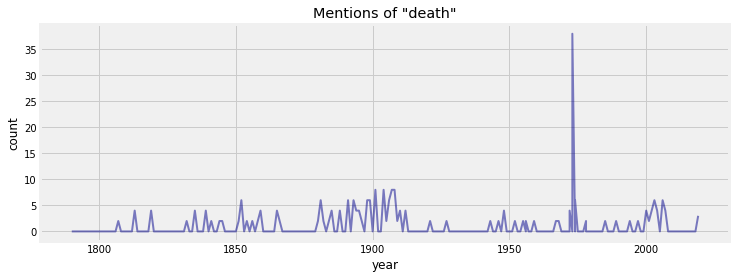

In [4]:
mentions_of_word('taxes', curve=True)
mentions_of_word('death', curve=True)

## 2. Pasting together all of the speeches for each President

Our next task is going to be to collect all of the SOTUs together for each individual president. To begin, let's think of how we might approach this using some `Table` operations. To make things easier to test, let's just form a small table that we can quickly manipulate.

In [5]:
icecream = Table().with_columns(
    'Flavor', make_array('strawberry', 'chocolate', 'chocolate', 'strawberry', 'chocolate', 'vanilla', 'vanilla'),
    'Variety', make_array('sugar free', 'dark', 'milk', 'dairy free', 'awesome', 'plain', 'sugar free')
)
icecream

Flavor,Variety
strawberry,sugar free
chocolate,dark
chocolate,milk
strawberry,dairy free
chocolate,awesome
vanilla,plain
vanilla,sugar free


Now, let's take this table and for each flavor, concatenate together all of the varieties into a single strong. To do this, we'll first group by `Flavor`, and pull out all of the flavors. Then we'll iterate through the flavors, and join all of the varieties. *Study this code to make sure you understand how it works!* Talk about it amongst yourselves!

In [6]:
flavors = icecream.group('Flavor').column('Flavor') #equivalent to .N in R data.table
flavors
# icecream.where('Flavor', 'vanilla') #returns rows which 'Falvor' column == 'vanilla'

array(['chocolate', 'strawberry', 'vanilla'], dtype='<U10')

In [7]:
flavors = icecream.group('Flavor')[0] # 0th column

varieties = []
for flavor in flavors:
    flavor_varieties = ', '.join(icecream.where('Flavor', flavor)[1])
    varieties.append(flavor_varieties)
    
varieties


# Table().with_columns('Flavor', flavors, 'Varieties', varieties)

['dark, milk, awesome', 'sugar free, dairy free', 'plain, sugar free']

Ok, now we want to do this for the SOTUs, where `Flavor -> President` and `Variety -> Transcript`. First, we'll get a list of all the presidents by grouping by `President`, applying the `min` operation to pull out the first year each was in office.

In [8]:
presidents = speeches.drop('Date', 'Transcript').group(['President'], min).sort('Year min')
presidents.show()

President,Year min
George Washington,1790
John Adams,1797
Thomas Jefferson,1801
James Madison,1809
James Monroe,1817
John Quincy Adams,1825
Andrew Jackson,1829
Martin van Buren,1837
John Tyler,1841
James K. Polk,1845


Who was president in 1849, and how long did he serve?

In [9]:
president_1849 = presidents.where('Year min', 1849)[0]
print(president_1849)

term_ended = int(speeches.drop('Date', 'Transcript').group(['President'], max).where('President', 'Zachary Taylor')[1])
print(term_ended)

['Zachary Taylor']
1849


Great! Next we'll iterate through the presidents (flavors) and join together their speeches (varieties). We'll call the resulting table `collected_speeches`.

In [10]:

transcripts = []
for prez in presidents[0]:
    collected_transcripts = ' '.join(speeches.where('President', prez)[3])
    transcripts.append(collected_transcripts)
    
collected_speeches = Table().with_columns('President', presidents[0], 'SOTUs', transcripts)
collected_speeches.show()

President,SOTUs
George Washington,Fellow-Citizens of the Senate and House of Representativ ...
John Adams,Gentlemen of the Senate and Gentlemen of the House of Re ...
Thomas Jefferson,The Senate and House of Representatives of the United S ...
James Madison,Fellow-Citizens of the Senate and House of Representati ...
James Monroe,Fellow-Citizens of the Senate and House of Representati ...
John Quincy Adams,Fellow Citizens of the Senate and of the House of Repre ...
Andrew Jackson,Fellow Citizens of the Senate and of the House of Repre ...
Martin van Buren,Fellow-Citizens of the Senate and House of Representati ...
John Tyler,To the Senate and House of Representatives of the Unite ...
James K. Polk,Fellow-Citizens of the Senate and of the House of Repre ...


## 3. Plotting counts by president

This now makes it convient to modify our earlier `mentions_of_word` function to count the number of times a word is used by each president, across all of their speeches. The following function `presidents_mentions_of_word` is then a simple modification of our earlier function.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def presidents_mentions_of_word(word, show_table=False):
    count = []
    for i in np.arange(collected_speeches.num_rows):
        matches = re.findall('\s%s\s' % word, collected_speeches.column('SOTUs')[i])
        count.append(len(matches))
    
    sotu = collected_speeches.drop('SOTUs').with_columns('Count', count)
    if (show_table):
        sotu.show(42)
    return sotu


Now we'll make a bar plot of the word counts across the presidents. Let's try this out on the proverbial two things we can't avoid in life: death and taxes.

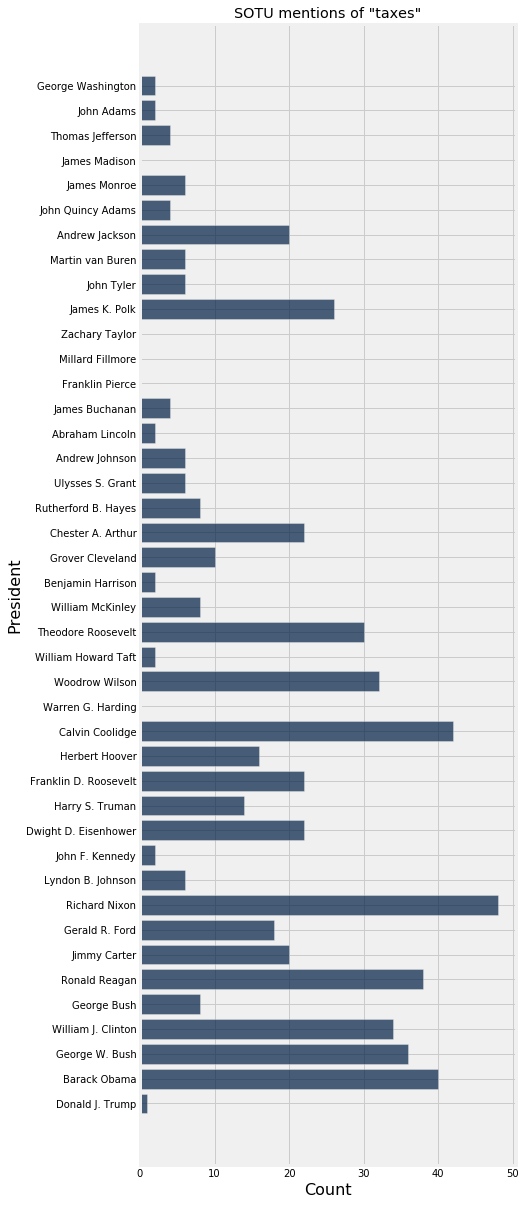

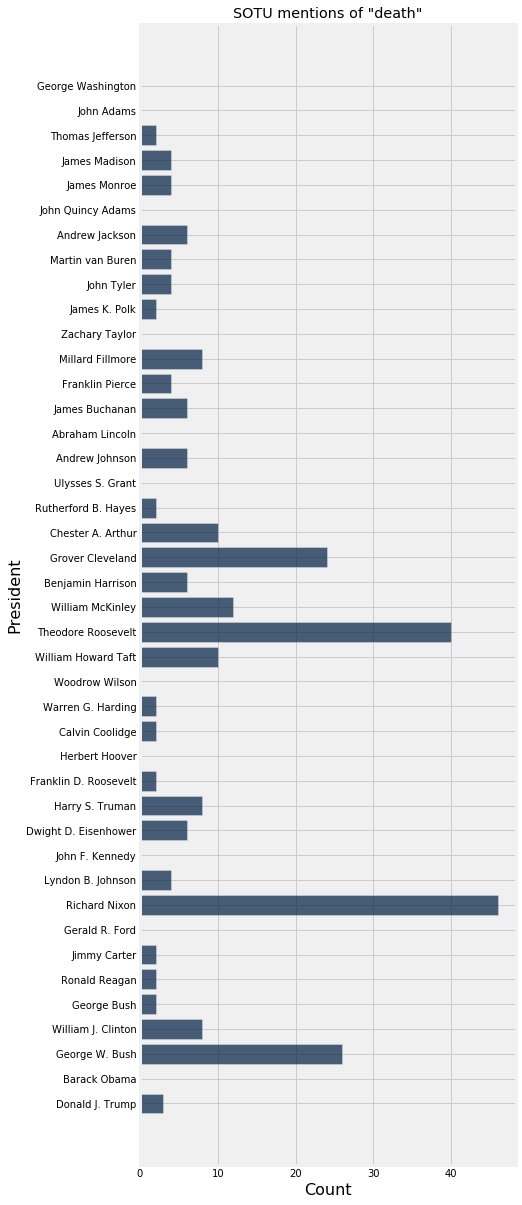

In [12]:
words = ['taxes', 'death']

for word in words:
    table = presidents_mentions_of_word(word, show_table=False)
    table.barh('President', 'Count')
    _ = plots.title('SOTU mentions of "%s"' % word)


###  Whence death?

Huh. It seems that Theodore Roosevelt and Richard Nixon were particularly interested in death. Can you understand why? Try browsing their addresses to understand the context in which death is mentioned. You can either look at the speeches here, or---more conveniently---browse them on [the American Presidency Project web site](https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union#Table%20of%20SOTU). What did you learn?  

They mentioned about death in the following couple of main context:
1. Death by accident or inevitable sacrifice of life should be paid 
2. Firemen and police men who meet death in the performance of their hazardous duty should be honored the memory of 
3. Combat death - War in Vietnam
4. Death penalty under the Federal Criminal Code
5. Vehicle death, death linked to alcohol

### Your turn!

Now explore the collection by trying out different words. Find a word or set of words that was of special interest to one or two Presidents. Give your plots and explain the context in which these words were mentioned by browsing the speeches.



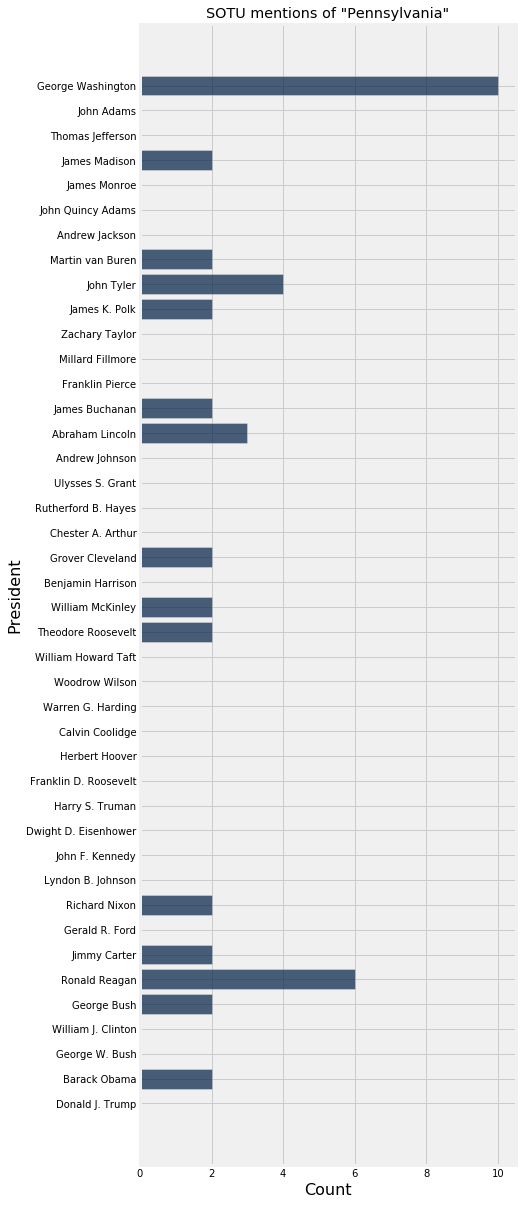

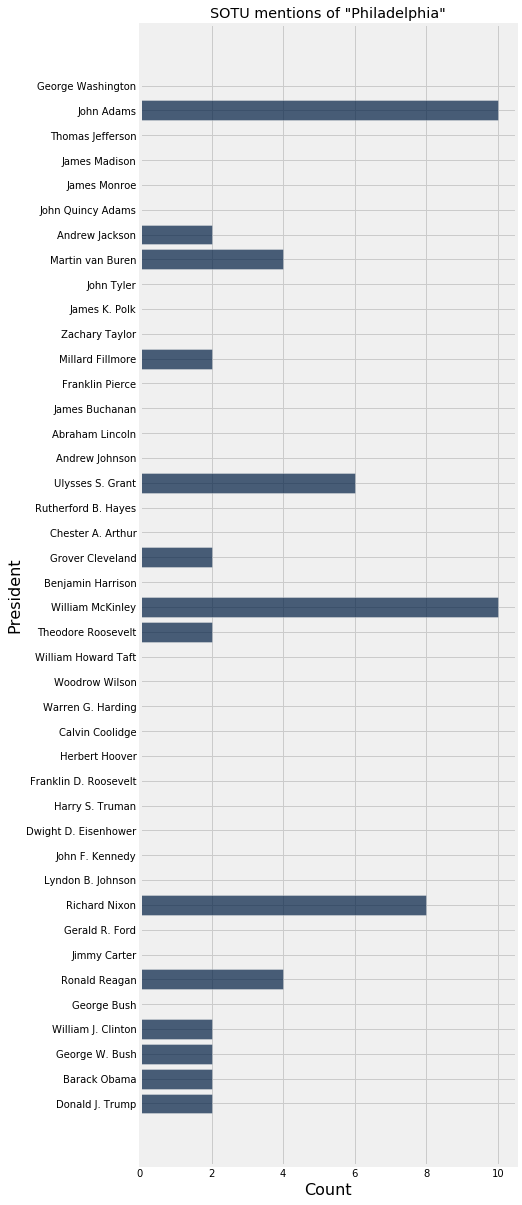

In [13]:
words = ['Pennsylvania','Philadelphia']

for word in words:
    table = presidents_mentions_of_word(word, show_table=False)
    table.barh('President', 'Count')
    _ = plots.title('SOTU mentions of "%s"' % word)

I did my undergrad in Philadelphia, Pennsylvania. So I chose these two words. From the plot, we can see that George Washington mentioned Pennsylvania for 10 times. John Adams and William Mckinley mentioned Philadelphia for 10 times as well.

Most of George Washington's speeches happened in Pennsylvania. However, he mentioned about Pennsylvania not all for good things. He talked about about there are some rioters and delinquent distillers opposed laws of the United States. John Adams and William Mckinkey mentioned about contagious sickness afflicted the city of Philadelphia, work of the commission of Philadelphia, the seat of the Government of the United States (transferred from Philadelphia to D.C.), exposition of products and manufactures held in Philadelphia...

## 4. Forming networks of Presidents

We're now going to plot some graphs after collecting data on which presidents mention which other presidents in their SOTUs. Think of it as kind of a SOTU Facebook.

Below is a small block of code (6 lines). What does it do? Write your description below, *before* running the code!

Create a Table with presidents column. 
Print "Computing mentions of"  
Then for each cell in the column, print itself out.  
Call presidents_mentions_of_word function, inside the function, it loops through each president and count how many times it was mentioned.  
Then return a new table with an additional column.


In [27]:
table = Table().with_column('President', presidents[0])
print("Computing mentions of:")
for prez in presidents[0]:
    print('\t "%s"' % prez)
    col = presidents_mentions_of_word(prez, show_table=False)
    table = table.with_column(prez, col[1])

Computing mentions of:
	 "George Washington"
	 "John Adams"
	 "Thomas Jefferson"
	 "James Madison"
	 "James Monroe"
	 "John Quincy Adams"
	 "Andrew Jackson"
	 "Martin van Buren"
	 "John Tyler"
	 "James K. Polk"
	 "Zachary Taylor"
	 "Millard Fillmore"
	 "Franklin Pierce"
	 "James Buchanan"
	 "Abraham Lincoln"
	 "Andrew Johnson"
	 "Ulysses S. Grant"
	 "Rutherford B. Hayes"
	 "Chester A. Arthur"
	 "Grover Cleveland"
	 "Benjamin Harrison"
	 "William McKinley"
	 "Theodore Roosevelt"
	 "William Howard Taft"
	 "Woodrow Wilson"
	 "Warren G. Harding"
	 "Calvin Coolidge"
	 "Herbert Hoover"
	 "Franklin D. Roosevelt"
	 "Harry S. Truman"
	 "Dwight D. Eisenhower"
	 "John F. Kennedy"
	 "Lyndon B. Johnson"
	 "Richard Nixon"
	 "Gerald R. Ford"
	 "Jimmy Carter"
	 "Ronald Reagan"
	 "George Bush"
	 "William J. Clinton"
	 "George W. Bush"
	 "Barack Obama"
	 "Donald J. Trump"


In [28]:
# display the table
table.show()

President,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James K. Polk,Zachary Taylor,Millard Fillmore,Franklin Pierce,James Buchanan,Abraham Lincoln,Andrew Johnson,Ulysses S. Grant,Rutherford B. Hayes,Chester A. Arthur,Grover Cleveland,Benjamin Harrison,William McKinley,Theodore Roosevelt,William Howard Taft,Woodrow Wilson,Warren G. Harding,Calvin Coolidge,Herbert Hoover,Franklin D. Roosevelt,Harry S. Truman,Dwight D. Eisenhower,John F. Kennedy,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump
George Washington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
John Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Thomas Jefferson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
James Madison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
James Monroe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
John Quincy Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Andrew Jackson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Martin van Buren,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
John Tyler,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
James K. Polk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Next, we're going to form a graph, or network, where the nodes are labeled by Presidents, and we have a directed edge from president $P_1$ to president $P_2$ if president $P_1$ mentions $P_2$ in any of his State of the Union addresses. So naturally, $P_2$ will have (almost certainly) served before $P_1$.

The next bit of code reads the table, and forms another table that we call `edge_table` corresponding to the nonzero entries, which will be the edges in our graph. Don't worry about the details; just execute this cell.


In [16]:
from_list = []
to_list = []
for i in np.arange(1,table.num_rows):
    for j in np.arange(len(table[i])):
        if table[i][j] > 0:
            from_list.append(table[0][j])
            to_list.append(table[0][i-1])

edge_table = Table().with_columns('From', from_list, 'To', to_list)
edge_table

From,To
Grover Cleveland,George Washington
Harry S. Truman,George Washington
Richard Nixon,George Washington
Gerald R. Ford,George Washington
Ronald Reagan,George Washington
William J. Clinton,George Washington
Barack Obama,George Washington
William McKinley,Thomas Jefferson
John F. Kennedy,Thomas Jefferson
Lyndon B. Johnson,Thomas Jefferson


Finally, the following code generates a graph (or network) using the `networkx` Python package. We'll give you some more code below for generating a different type of graph.


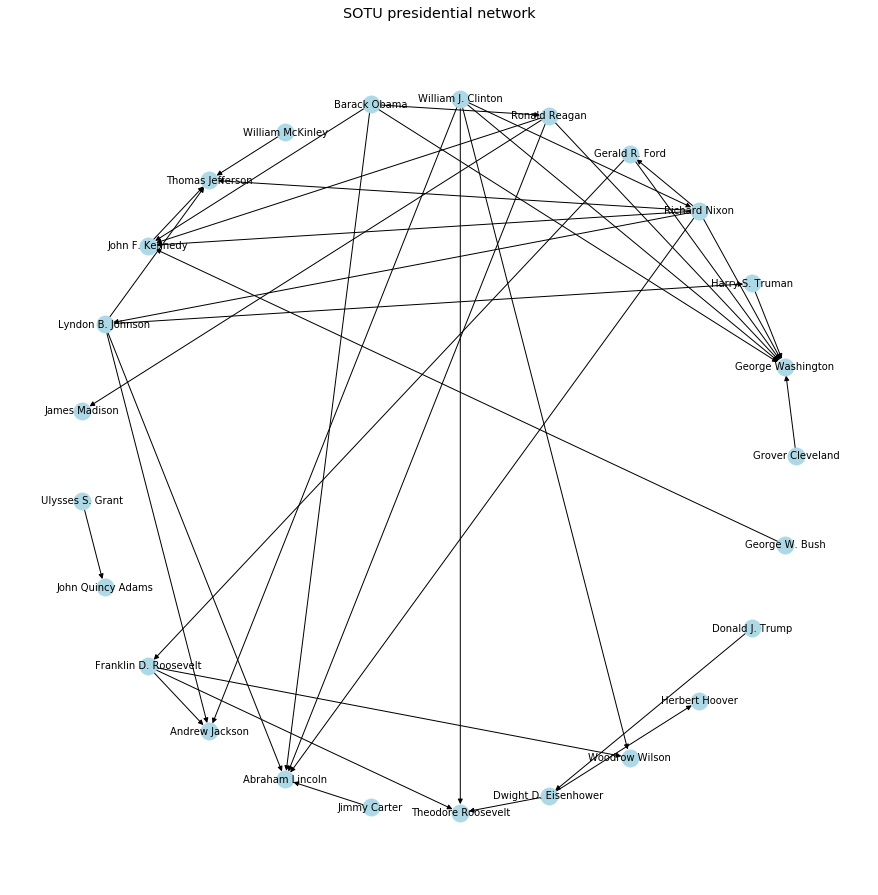

In [17]:
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
for i in np.arange(len(from_list)):
    G.add_edge(from_list[i], to_list[i])

# Plot it
fig = plt.figure()
fig.set_size_inches(12,12)
nx.draw_circular(G, with_labels=True, node_color='lightblue', font_size=10)
plt.title('SOTU presidential network')
plt.show()


Describe in words some of the features of this network that you observe. Who mentions whom? Who is the most mentioned? The second most? Could some of the edges be wrongly included or excluded? Explain.

George Washiton was mentioned the most. He was mentioned by Harry Truman, Richard Nixon, Gerald R. Ford, Ronald Reagan, William J. Clinton, Barack Obama and Grover Cleveland. The second most be-mentioned are Abraham Lincoln, Thomas Jefferson and John F. Kennedy. Yes, for example, if someone mentioned President Lincoln instead of Abraham Lincoln, Franklin Roosevelt rather than Franklin D. Roosevelt, that may cause wrongly exclusion.

## 5. Making a bipartite graph

Now let's display the same information in a different form. We'll present it as a "bipartite graph." This means there are two parts: Nodes on the left link to nodes on the right.  We wrote a function for you that generates such a plot. You don't need to understand or modify this code.


In [18]:
# function to draw bipartite from from list of edges of the form [(name0, name1), ...(name0, name1)]
# you don't need to change this
def make_bipartite_graph(edges):
    new_edges = [(edge[0], edge[1]+' ') for edge in edges]
    from_list = {edge[0] for edge in new_edges}
    to_list = {edge[1] for edge in new_edges}

    G = nx.DiGraph()
    G.add_nodes_from(from_list, bipartite=0)
    G.add_nodes_from(to_list, bipartite=1)
    G.add_edges_from(new_edges)

    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
    bottom_nodes = set(G) - top_nodes


    l, r = nx.bipartite.sets(G, top_nodes)
    pos = {}
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    fig = plt.figure()
    fig.set_size_inches(12,12)
    nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', alpha=0.9)
    plt.show()

    
    


Now generate the bipartite graph for "Presidential Facebook" by calling the function `make_bipartite_graph`. To do this, we first form a list of pairs $(P_1, P_2)$, by looping over the rows in `edge_table`. Then we pass in this list to `make_bipartite_graph`

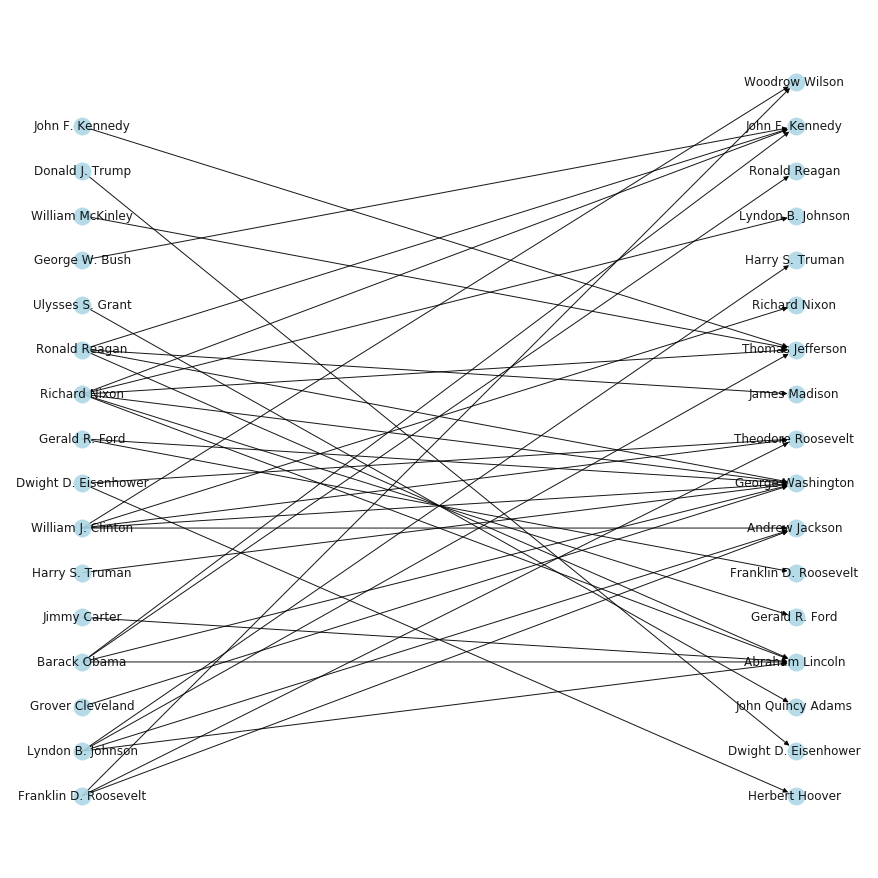

In [19]:
edge_list = [(edge_table[0][i], edge_table[1][i]) for i in np.arange(edge_table.num_rows)]
make_bipartite_graph(edge_list)


## 6. Your turn!

To complete this lab, we'd now like you to do the following. Find several names in the SOTU addresses of people (or places or other proper nouns) other than presidents. Then, form a list of which presidents mention each of those people, and generate the plot as a bipartite graph.

Try to find about 10 or so names/places/things to compute over, which are mentioned by several presidents, so you get an interesting plot.  Just to make sure you know how to get going, here is an example with
the targets ['Gorbachev', 'Churchill', 'Stalin', 'Lenin', 'Hitler', 'Putin']


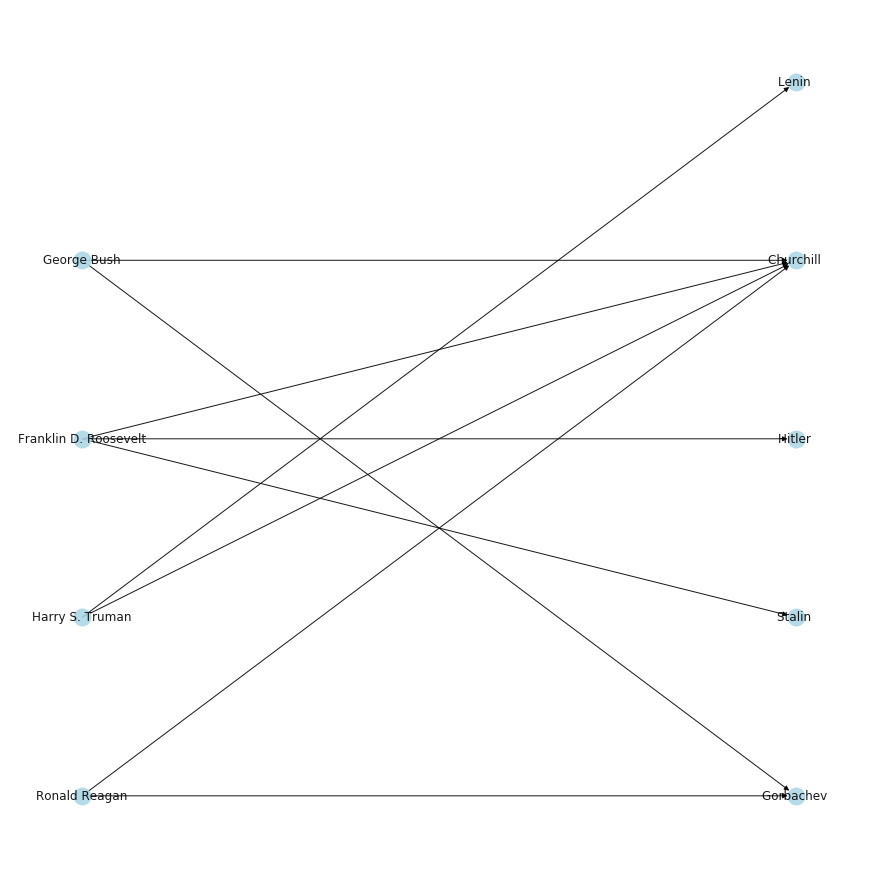

In [20]:
edge_list = []

for name in ['Gorbachev', 'Churchill', 'Stalin', 'Lenin', 'Hitler', 'Putin']:
    table = presidents_mentions_of_word(name)
    for prez in table.where('Count', are.above(0)).column('President'):
        edge_list.append((prez, name))

make_bipartite_graph(edge_list)

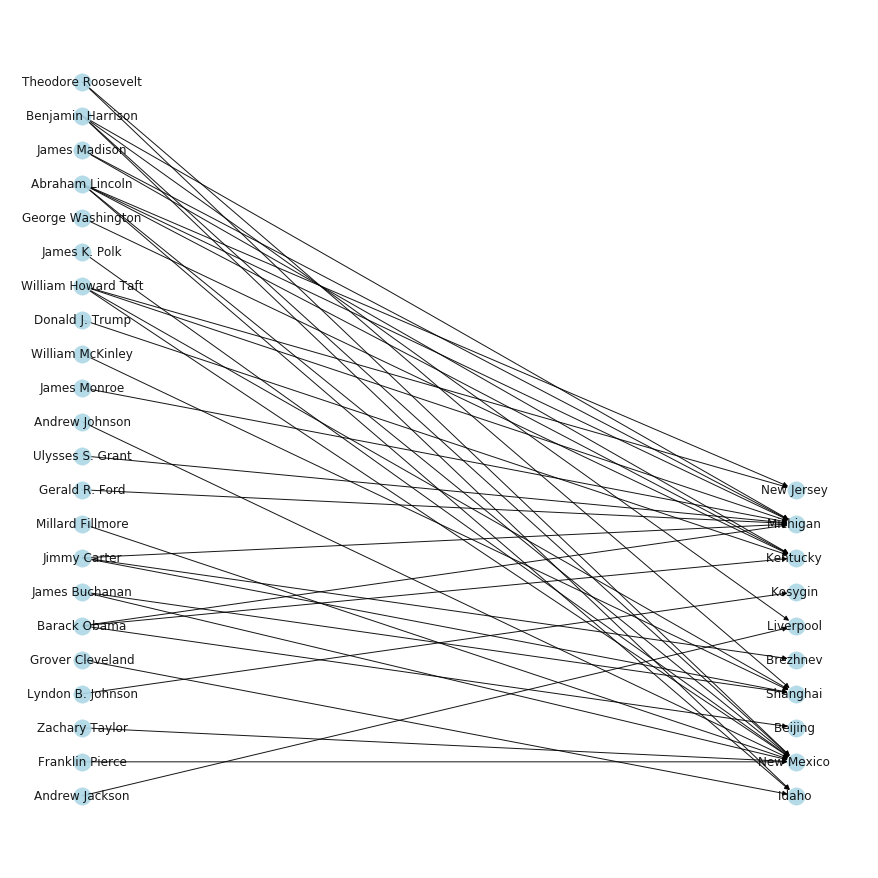

In [52]:
edge_list = []

for name in ['Liverpool', 'Brezhnev','Kosygin','New Mexico','Kentucky','Michigan','Denver','Idaho','New Jersey','Beijing','Shanghai']:
    table = presidents_mentions_of_word(name)
    for prez in table.where('Count', are.above(0)).column('President'):
        edge_list.append((prez, name))

make_bipartite_graph(edge_list)